# Tools

In [1]:
import time
from pathlib import Path
from datetime import datetime

import torch
import torch.cuda as cuda
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import random_split, DataLoader
from torch.cuda.amp import GradScaler
import monai
import gdown
import pandas as pd
import torchio as tio
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import seaborn as sns


sns.set()
plt.rcParams['figure.figsize'] = 12, 8
monai.utils.set_determinism()

print('Last run on', time.ctime())

%load_ext tensorboard

C:\Users\Karim\anaconda3\envs\Torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Last run on Sun Apr  2 19:40:13 2023


## DATA

In [2]:
class MedicalDecathlonDataModule(pl.LightningDataModule):
    def __init__(self, task, google_id, batch_size, train_val_ratio):
        super().__init__()
        self.task = task
        self.google_id = google_id
        self.batch_size = batch_size
        self.dataset_dir = Path(task)
        self.train_val_ratio = train_val_ratio
        self.subjects = None
        self.test_subjects = None
        self.preprocess = None
        self.transform = None
        self.train_set = None
        self.val_set = None
        self.test_set = None
    
    def get_max_shape(self, subjects):
        import numpy as np
        dataset = tio.SubjectsDataset(subjects)
        shapes = np.array([s.spatial_shape for s in dataset])
        return shapes.max(axis=0)
    
    def download_data(self):
        if not self.dataset_dir.is_dir():
            url = f'https://drive.google.com/uc?id={self.google_id}'
            output = f'{self.task}.tar'
            gdown.download(url, output, quiet=False)
            !tar xf {output}

        def get_niis(d):
            return sorted(p for p in d.glob('*.nii*') if not p.name.startswith('.'))

        image_training_paths = get_niis(self.dataset_dir / 'imagesTr')
        label_training_paths = get_niis(self.dataset_dir / 'labelsTr')
        image_test_paths = get_niis(self.dataset_dir / 'imagesTs')
        return image_training_paths, label_training_paths, image_test_paths

    def prepare_data(self):
        image_training_paths, label_training_paths, image_test_paths = self.download_data()

        self.subjects = []
        for image_path, label_path in zip(image_training_paths, label_training_paths):
            # 'image' and 'label' are arbitrary names for the images
            subject = tio.Subject(
                image=tio.ScalarImage(image_path),
                label=tio.LabelMap(label_path)
            )
            self.subjects.append(subject)
        
        self.test_subjects = []
        for image_path in image_test_paths:
            subject = tio.Subject(image=tio.ScalarImage(image_path))
            self.test_subjects.append(subject)
    
    def get_preprocessing_transform(self):
        preprocess = tio.Compose([
            tio.RescaleIntensity((-1, 1)),
            tio.CropOrPad(self.get_max_shape(self.subjects + self.test_subjects)),
            tio.EnsureShapeMultiple(8),  # for the U-Net
            tio.OneHot(),
        ])
        return preprocess
    
    def get_augmentation_transform(self):
        augment = tio.Compose([
            tio.RandomAffine(),
            tio.RandomGamma(p=0.5),
            tio.RandomNoise(p=0.5),
            tio.RandomMotion(p=0.1),
            tio.RandomBiasField(p=0.25),
        ])
        return augment

    def setup(self, stage=None):
        num_subjects = len(self.subjects)
        num_train_subjects = int(round(num_subjects * self.train_val_ratio))
        num_val_subjects = num_subjects - num_train_subjects
        splits = num_train_subjects, num_val_subjects
        train_subjects, val_subjects = random_split(self.subjects, splits)

        self.preprocess = self.get_preprocessing_transform()
        augment = self.get_augmentation_transform()
        self.transform = tio.Compose([self.preprocess, augment])

        self.train_set = tio.SubjectsDataset(train_subjects, transform=self.transform)
        self.val_set = tio.SubjectsDataset(val_subjects, transform=self.preprocess)
        self.test_set = tio.SubjectsDataset(self.test_subjects, transform=self.preprocess)

    def train_dataloader(self):
        return DataLoader(self.train_set, self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.val_set, self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_set, self.batch_size)
    
    

print('Last run on', time.ctime())

Last run on Sun Apr  2 19:40:13 2023


In [3]:
data = MedicalDecathlonDataModule(
    task='Task04_Hippocampus',
    google_id='1RzPB1_bqzQhlWvU-YGvZzhx2omcDh38C',
    batch_size=16,
    train_val_ratio=0.8,
)

print('Last run on', time.ctime())

Last run on Sun Apr  2 19:40:13 2023


In [4]:
data.prepare_data()
data.setup()

print('Training data:  ', len(data.train_set))
print('Validation data: ', len(data.val_set))
print('Test data:      ', len(data.test_set))



print('Last run on', time.ctime())

Training data:   208
Validation data:  52
Test data:       130
Last run on Sun Apr  2 19:40:16 2023


# Exercise 1

In [5]:
class Unet(nn.Module):
    def __init__(self, loss_fn, learning_rate, optimizer_class):
        super().__init__()
        self.lr = learning_rate
        self.model = None
        self.criterion = loss_fn
        self.optimizer_class = optimizer_class
        
    def init_model(self, Dimensions=3, In_channels=1, Out_channels=3, Channels=(8, 16, 32, 64), Strides=(2, 2, 2) ):
        self.model = monai.networks.nets.UNet(dimensions=Dimensions,
                                 in_channels= In_channels,
                                 out_channels= Out_channels,
                                 channels= Channels,
                                 strides=Strides,
                                             )
        print("Model initialized !")
        
    
    def configure_optimizers(self):
        self.optimizer = self.optimizer_class(self.model.parameters(), lr=self.lr)
    
    def prepare_dataloaders(self, data):
        # Prepare the dataloaders
        self.train_data = data.train_dataloader()
        self.test_data = data.test_dataloader()
        self.val_data = data.val_dataloader()

    def train(self, nb_epochs):
        hist = {"train_loss": [], "val_loss": []}
        
        scaler = GradScaler()
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model.to(device)
        for epoch in range(nb_epochs):
            for batch in self.train_data:
                # unpack data
                x, y = batch['image']['data'].to(device), batch['label']['data'].to(device)
                
                self.optimizer.zero_grad()
                
                # Froward step
                with torch.autocast(device_type='cuda', dtype=torch.float16):
                    y_pred = self.model(x)
                    
                    # calculate the loss
                    loss = self.criterion(y_pred, y)

                # backprop
                scaler.scale(loss).backward()
                scaler.step(self.optimizer)

                # Updates the scale for next iteration.
                scaler.update()
                

                print("Epoch {}/{} : Train_loss = {:.4f}".format(epoch+1, nb_epochs, loss), end ="\r")
            
           
            # validation step
            val_loss = self.validation_step()
            
            # Saving the training history
            hist["train_loss"].append(loss.cpu().data.numpy())
            hist["val_loss"].append(val_loss.cpu().data.numpy())
            
            print("Epoch {}/{} : Train_loss = {:.4f}, Val_loss = {:.4f}".format(epoch+1,nb_epochs, loss, val_loss), end ="\r")
            print("")
            
        return hist    
            
            
            
    def validation_step(self):
        val_loss = []
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        for batch in self.val_data:
            # unpack data
            x, y = batch['image']['data'].to(device), batch['label']['data'].to(device)
            # Froward step
            y_pred = self.model(x)

            # calculate the loss
            loss = self.criterion(y_pred, y)

            val_loss.append(loss)
            
        return sum(val_loss)/len(val_loss)
            
    

print('Last run on', time.ctime())

Last run on Sun Apr  2 19:40:16 2023


In [6]:
# instanciation of Uniet class
network = Unet(loss_fn= monai.losses.DiceCELoss(softmax=True), learning_rate = 1e-2, optimizer_class= Adam)

# initialize Unet model
network.init_model()

# configure optimizer
network.configure_optimizers()

# prepare dataloaders
network.prepare_dataloaders(data)

Model initialized !


In [7]:
# Train the model
nb_epochs = 10
hist = network.train(nb_epochs)

print('Last run on', time.ctime())

Epoch 1/10 : Train_loss = 0.8103, Val_loss = 0.7853
Epoch 2/10 : Train_loss = 0.5911, Val_loss = 0.5665
Epoch 3/10 : Train_loss = 0.5340, Val_loss = 0.4936
Epoch 4/10 : Train_loss = 0.4711, Val_loss = 0.4496
Epoch 5/10 : Train_loss = 0.4206, Val_loss = 0.4015
Epoch 6/10 : Train_loss = 0.3281, Val_loss = 0.3068
Epoch 7/10 : Train_loss = 0.2602, Val_loss = 0.2431
Epoch 8/10 : Train_loss = 0.2365, Val_loss = 0.2107
Epoch 9/10 : Train_loss = 0.2122, Val_loss = 0.1989
Epoch 10/10 : Train_loss = 0.2034, Val_loss = 0.1890
Last run on Sun Apr  2 19:42:30 2023


## Training graphs

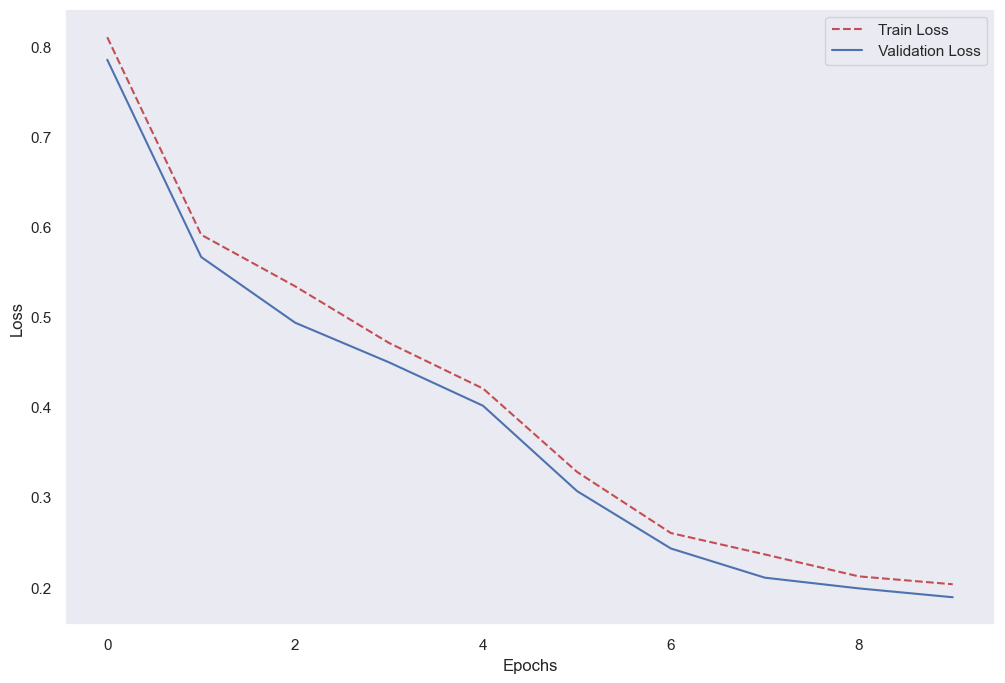

Last run on Sun Apr  2 20:49:59 2023


In [21]:
plt.figure()
plt.plot(hist["train_loss"],  'r--', label=" Train Loss")
plt.plot(hist["val_loss"], label=" Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()


plt.grid()
plt.savefig("./figures/Unet_10epochs.pdf")
plt.show()


print('Last run on', time.ctime())

## Saving a trained model

In [9]:
# Saving a trained model
torch.save(network.model.state_dict(), "./saved_models/Unet_10epochs")
print('Last run on', time.ctime())

Last run on Sun Apr  2 19:42:30 2023


# Exercise 2

### Adding a fine-tune function to the previous class

In [10]:
class Unet(nn.Module):
    def __init__(self, loss_fn, learning_rate, optimizer_class):
        super().__init__()
        self.lr = learning_rate
        self.model = None
        self.criterion = loss_fn
        self.optimizer_class = optimizer_class
        
    def init_model(self, Dimensions=3, In_channels=1, Out_channels=3, Channels=(8, 16, 32, 64), Strides=(2, 2, 2) ):
        self.model = monai.networks.nets.UNet(dimensions=Dimensions,
                                 in_channels= In_channels,
                                 out_channels= Out_channels,
                                 channels= Channels,
                                 strides=Strides,
                                             )
        print("Model initialized !")
        
    
    def configure_optimizers(self):
        self.optimizer = self.optimizer_class(self.model.parameters(), lr=self.lr)
    
    def prepare_dataloaders(self, data):
        # Prepare the dataloaders
        self.train_data = data.train_dataloader()
        self.test_data = data.test_dataloader()
        self.val_data = data.val_dataloader()

    def train(self, nb_epochs):
        hist = {"train_loss": [], "val_loss": []}
        
        scaler = GradScaler()
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model.to(device)
        for epoch in range(nb_epochs):
            for batch in self.train_data:
                # unpack data
                x, y = batch['image']['data'].to(device), batch['label']['data'].to(device)
                
                self.optimizer.zero_grad()
                
                # Froward step
                with torch.autocast(device_type='cuda', dtype=torch.float16):
                    y_pred = self.model(x)
                    
                    # calculate the loss
                    loss = self.criterion(y_pred, y)

                # backprop
                scaler.scale(loss).backward()
                scaler.step(self.optimizer)

                # Updates the scale for next iteration.
                scaler.update()
                print("Epoch {}/{} : Train_loss = {:.4f}".format(epoch+1, nb_epochs, loss), end ="\r")
            # validation step
            val_loss = self.validation_step()
            
            # Saving the training history
            hist["train_loss"].append(loss.cpu().data.numpy())
            hist["val_loss"].append(val_loss.cpu().data.numpy())
            
            print("Epoch {}/{} : Train_loss = {:.4f}, Val_loss = {:.4f}".format(epoch+1,nb_epochs, loss, val_loss), end ="\r")
            print("")
            
        return hist            
            
    def validation_step(self):
        val_loss = []
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        for batch in self.val_data:
            # unpack data
            x, y = batch['image']['data'].to(device), batch['label']['data'].to(device)
            # Froward step
            y_pred = self.model(x)

            # calculate the loss
            loss = self.criterion(y_pred, y)

            val_loss.append(loss)
            
        return sum(val_loss)/len(val_loss)
    
    
    # The fine tune function added for this execise
    def set_fine_tune(self, load= False):
        # if load is True, Load the parameters of previous trained model
        # if load is False, initialiser a new model
        if load:
            # Load the weights of a pre trained model
            self.model.load_state_dict(torch.load("./saved_models/Unet_100epochs"))
        else:
            # initialize the model with random weights
            self.model.apply(self.model._initialize_weights)
            
        # Freeze the parameters of all the layers except the last one
        for name, param in self.model.named_parameters():
            # corresponding to the name of the last layer
            if 'model.2.conv' not in name:
                param.requires_grad = False
            
    

print('Last run on', time.ctime())

Last run on Sun Apr  2 19:42:30 2023


In [11]:
# instanciation of Uniet class
network = Unet(loss_fn= monai.losses.DiceCELoss(softmax=True), learning_rate = 1e-2, optimizer_class= Adam)

# initialize Unet model
network.init_model()

# configure optimizer
network.configure_optimizers()

# prepare dataloaders
network.prepare_dataloaders(data)

print('Last run on', time.ctime())

Model initialized !
Last run on Sun Apr  2 19:42:30 2023


Load the previous model.

In [12]:
# load the previous trained model to retrain and fine tune his last layer
network.set_fine_tune(load=True)


print('Last run on', time.ctime())

Last run on Sun Apr  2 19:42:30 2023


Now we are going to check is the function fine tune freezes all the layers except the last one.

In [13]:
# checking if the last layer is not freezed
for name, param in network.model.named_parameters():
    if param.requires_grad:
        print(f"{name} is Trainable")
    else:
        print(f"{name} is freezed")
        
        
print('Last run on', time.ctime())

model.0.conv.weight is freezed
model.0.conv.bias is freezed
model.0.adn.A.weight is freezed
model.1.submodule.0.conv.weight is freezed
model.1.submodule.0.conv.bias is freezed
model.1.submodule.0.adn.A.weight is freezed
model.1.submodule.1.submodule.0.conv.weight is freezed
model.1.submodule.1.submodule.0.conv.bias is freezed
model.1.submodule.1.submodule.0.adn.A.weight is freezed
model.1.submodule.1.submodule.1.submodule.conv.weight is freezed
model.1.submodule.1.submodule.1.submodule.conv.bias is freezed
model.1.submodule.1.submodule.1.submodule.adn.A.weight is freezed
model.1.submodule.1.submodule.2.conv.weight is freezed
model.1.submodule.1.submodule.2.conv.bias is freezed
model.1.submodule.1.submodule.2.adn.A.weight is freezed
model.1.submodule.2.conv.weight is freezed
model.1.submodule.2.conv.bias is freezed
model.1.submodule.2.adn.A.weight is freezed
model.2.conv.weight is Trainable
model.2.conv.bias is Trainable
Last run on Sun Apr  2 19:42:30 2023


The code works perfectly fine !

# Exercise 3

In order to solve the questions of the exercice we are going to change a little bit the previous class so it matches the requirements of the problem. So we gonna create a new class to ensure that the samples are equiprobably chosen. And in a second time we are going to modify our training loop the function prepare_data to be sure that we have always the same number of ittérations.

In [14]:
import torch.utils.data as Data


# Uniform probabilty of picking a specific image in the dataset
class UniformSampler(Data.Sampler):
    def __init__(self, dataset):
        self.dataset = dataset
    
    def __iter__(self):
        indices = torch.randperm(len(self.dataset))
        return iter(indices.tolist())
    
    def __len__(self):
        return len(self.dataset)
    
    
    
class Unet(nn.Module):
    def __init__(self, loss_fn, learning_rate, optimizer_class):
        super().__init__()
        self.lr = learning_rate
        self.model = None
        self.criterion = loss_fn
        self.optimizer_class = optimizer_class
        
    def init_model(self, Dimensions=3, In_channels=1, Out_channels=3, Channels=(8, 16, 32, 64), Strides=(2, 2, 2) ):
        self.model = monai.networks.nets.UNet(dimensions=Dimensions,
                                 in_channels= In_channels,
                                 out_channels= Out_channels,
                                 channels= Channels,
                                 strides=Strides,
                                             )
        print("Model initialized !")
        
    
    def configure_optimizers(self):
        self.optimizer = self.optimizer_class(self.model.parameters(), lr=self.lr)
    
    # The function has been modified to match the requirements
    def prepare_dataloaders(self, data, batch_size):
        
        self.batch_size = batch_size
        train_sampler = UniformSampler(data.train_set)
        test_sampler = UniformSampler(data.test_set)
        val_sampler = UniformSampler(data.val_set)
        
        # Prepare the dataloaders
        
        self.train_data = DataLoader(data.train_set, self.batch_size, sampler=train_sampler)
        self.test_data = DataLoader(data.test_set, self.batch_size, sampler=test_sampler)
        self.val_data = DataLoader(data.val_set, self.batch_size, sampler=val_sampler)
        
        
    def init_train_dataloader(self, data):
        train_sampler = UniformSampler(data.train_set)
        self.train_data = DataLoader(data.train_set, self.batch_size, sampler=train_sampler)
        
        
    def train(self, dataset, nb_epochs=10, Nit = 100):
        hist = {"train_loss": [], "val_loss": []}
        
        scaler = GradScaler()
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model.to(device)
        
        # Initialiser le compteur d'itérations
        iteration = 0
        for epoch in range(nb_epochs):
            iteration = 0
            
            #initialize our train dataset
            self.init_train_dataloader(dataset)
            
            # Boucle while pour les itérations
            while (iteration <= Nit):
                for batch in self.train_data:
                    # unpack data
                    x, y = batch['image']['data'].to(device), batch['label']['data'].to(device)

                    self.optimizer.zero_grad()

                    # Froward step
                    with torch.autocast(device_type='cuda', dtype=torch.float16):
                        y_pred = self.model(x)

                        # calculate the loss
                        loss = self.criterion(y_pred, y)

                    # backprop
                    scaler.scale(loss).backward()
                    scaler.step(self.optimizer)

                    # Updates the scale for next iteration.
                    scaler.update()
                
                    print("Epoch {}/{}, Step {}/{}: Train_loss = {:.4f}".format(epoch+1, nb_epochs,iteration, Nit, loss), end ="\r")
                    
                    iteration += 1
                    if iteration >= Nit:
                        break
                        
            hist["train_loss"].append(loss.cpu().data.numpy())
            # validation step
            val_loss = self.validation_step()


            # Saving the training history
            hist["val_loss"].append(val_loss.cpu().data.numpy())

            print("Epoch {}/{} : Train_loss = {:.4f}, Val_loss = {:.4f}".format(epoch+1,nb_epochs,  hist["train_loss"][-1], val_loss), end ="\r")
            print("")
            
        return hist            
            
    def validation_step(self):
        val_loss = []
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        for batch in self.val_data:
            # unpack data
            x, y = batch['image']['data'].to(device), batch['label']['data'].to(device)
            # Froward step
            y_pred = self.model(x)

            # calculate the loss
            loss = self.criterion(y_pred, y)

            val_loss.append(loss)
            
        return sum(val_loss)/len(val_loss)
    
    
    # The fine tune function added for this execise
    def set_fine_tune(self, load= False):
        # if load is True, Load the parameters of previous trained model
        # if load is False, initialiser a new model
        if load:
            # Load the weights of a pre trained model
            self.model.load_state_dict(torch.load("./saved_models/Unet_100epochs"))
        else:
            # initialise the model with random weights
            self.model.apply(self.model._initialize_weights)
            
        # Freeze the parameters of all the layers except the last one
        for name, param in self.model.named_parameters():
            # corresponding to the name of the last layer
            if 'model.2.conv' not in name:
                param.requires_grad = False
            
    

print('Last run on', time.ctime())


Last run on Sun Apr  2 19:42:30 2023


In [15]:
# instanciation of Uniet class
network = Unet(loss_fn= monai.losses.DiceCELoss(softmax=True), learning_rate = 1e-2, optimizer_class= Adam)

# initialize Unet model
network.init_model()

# configure optimizer
network.configure_optimizers()

# prepare dataloaders
batch_size = 16
network.prepare_dataloaders(data, batch_size)

print('Last run on', time.ctime())

Model initialized !
Last run on Sun Apr  2 19:42:30 2023


In [16]:
# Train the model with the new method
Nb_epochs = 10
nit = 250
hist3 = network.train(data, Nb_epochs, nit)
print('Last run on', time.ctime())

Epoch 1/10 : Train_loss = 0.1699, Val_loss = 0.1687
Epoch 2/10 : Train_loss = 0.1631, Val_loss = 0.1471
Epoch 3/10 : Train_loss = 0.1567, Val_loss = 0.1479
Epoch 4/10 : Train_loss = 0.1493, Val_loss = 0.1399
Epoch 5/10 : Train_loss = 0.1458, Val_loss = 0.1468
Epoch 6/10 : Train_loss = 0.1563, Val_loss = 0.1328
Epoch 7/10 : Train_loss = 0.1522, Val_loss = 0.1398
Epoch 8/10 : Train_loss = 0.1354, Val_loss = 0.1389
Epoch 9/10 : Train_loss = 0.1396, Val_loss = 0.1369
Epoch 10/10 : Train_loss = 0.1304, Val_loss = 0.1376
Last run on Sun Apr  2 20:21:28 2023


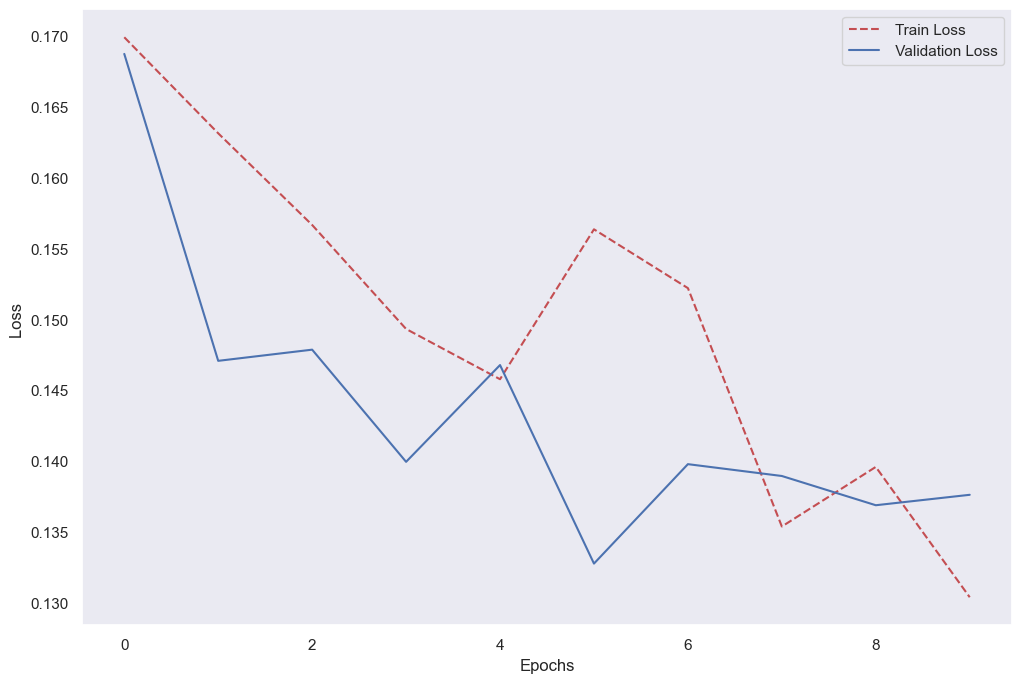

Last run on Sun Apr  2 20:50:07 2023


In [22]:
plt.figure()
plt.plot(hist3["train_loss"],  'r--', label=" Train Loss")
plt.plot(hist3["val_loss"], label=" Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss ")
plt.legend()


plt.grid()
plt.savefig("./figures/Unet_10epochs_EX3.pdf")
plt.show()
print('Last run on', time.ctime())

In [18]:
# Saving a trained model
torch.save(network.model.state_dict(), "./saved_models/Unet_10epochs_250it_ex3")
print('Last run on', time.ctime())

Last run on Sun Apr  2 20:21:28 2023


## Comparing the two training curves (Ex1 - Ex3)

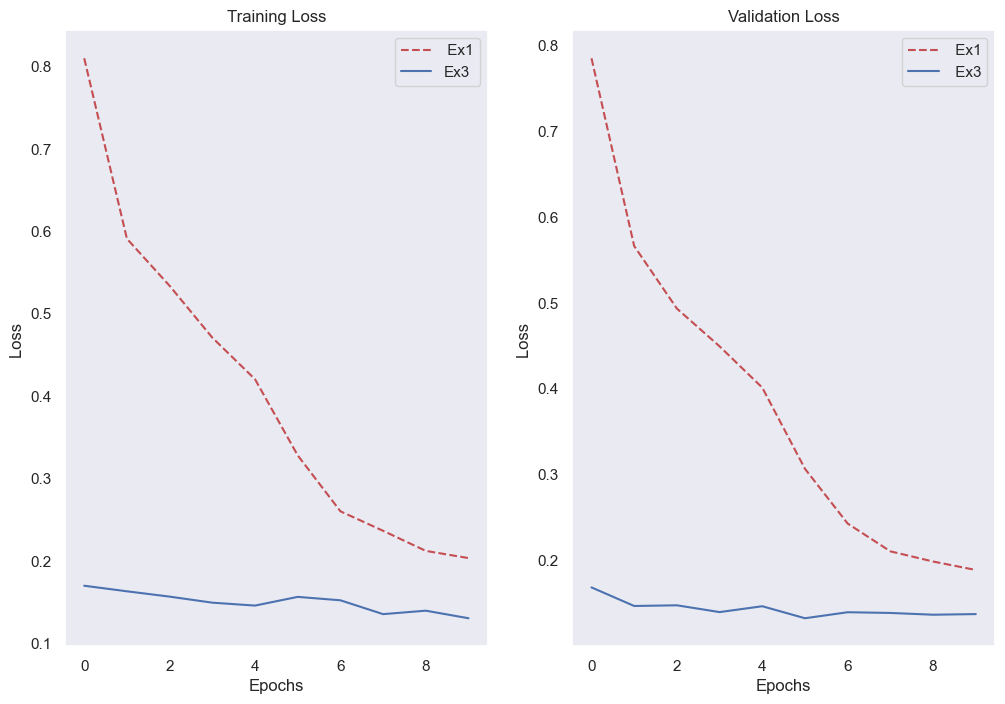

Last run on Sun Apr  2 20:50:11 2023


In [23]:
plt.figure()


# Comparing Training Loss
ax1 = plt.subplot(121)
plt.plot(hist["train_loss"],  'r--', label=" Ex1")
plt.plot(hist3["train_loss"], label="Ex3")
plt.xlabel("Epochs")
plt.ylabel("Loss ")
plt.title("Training Loss")
plt.legend()


# Comparing validation Loss
ax2 = plt.subplot(122)
plt.plot(hist["val_loss"],  'r--', label=" Ex1")
plt.plot(hist3["val_loss"], label=" Ex3")
plt.xlabel("Epochs")
plt.ylabel("Loss ")
plt.title("Validation Loss")
plt.legend()


ax1.grid()
ax2.grid()
plt.savefig("./figures/Unet_compare_Ex1&Ex2.pdf")
plt.show()

print('Last run on', time.ctime())